<div>
<img src="https://www.th-koeln.de/img/logo.svg" width="100">
</div>

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
<br />Dieses Werk ist lizenziert unter einer <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Namensnennung - Weitergabe unter gleichen Bedingungen 4.0 International Lizenz</a>.

Prof. Dr. Johanna Friederike May <br>
Technische Hochschule Köln <br>
Fakultät für Informations-, Medien- und Elektrotechnik (F07)<br>
Institut für Elektrische Energietechnik (IET)<br>
Cologne Institute for Renewable Energy (CIRE)<br>

# Systemtechnik für Energieeffizienz - Daten analysieren

<div class="alert alert-block alert-info"><b>Lernziele für diese Einheit: </b>

- Eingangs-Daten für die Analyse aus Messungen und Recherchen überprüfen
- Daten plausibel und transparent bereinigen
- Normen als Quelle von Anforderungen nutzen
- Energiedaten selbst erzeugen anhand von Annahmen
- Ergebnisse überprüfen (ist so viel Energieeinsparung plausibel?)
</div>

Bibliotheken importieren

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns; sns.set()
sns.set(style="darkgrid")
import pandas as pd
import datetime as dt
import os
import math
import time
#import dates
import datetime
import pytz
import re
import random
import h5py

/usr/lib64/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Grafikparameter für die Diagramme festlegen:

In [2]:
sns.set(style = "darkgrid")
sns.set(rc = {"figure.figsize" : (16, 5)})
# matplotlib
linw = 2 # Linienbreite
lincol = 'orange' # Linienfarbe
lincol2 = 'red'
rcParams['font.family'] = 'sans-serif' # serifenfreie Schrift in Abbildungen
rcParams['font.size'] = 16 # Schriftgröße

## Plausible Daten? 

### Beispiel 1: Betrachtung eines Bäckereibetriebs, der seinen Verbrauch angibt

In [ ]:
EBackJahr = 2000 # jährlicher Stromverbrauch in kWh/a
Mehl = 5000 # jährlicher Mehlverbrauch in kg/a

Kann das sein?

In [ ]:
Backtage = 300
EBackTag = EBackJahr/Backtage
print('Durchschnittlicher Stromverbrauch pro Backtag: ' +str(np.round(EBackTag,1)) +' kWh/d')

In [ ]:
MehlTag = Mehl/Backtage
print('Durchschnittlicher Mehlverbrauch pro Backtag: ' +str(np.round(MehlTag,1))+ ' kg/d')

In [ ]:
MehlProBrot = np.linspace(0.5,1,2) # ca. 500 - 1000 g Mehl pro Brot, hier in kg
BroteProTag = MehlTag/MehlProBrot
print(str(np.round(BroteProTag[1],1)) + '-' +str(np.round(BroteProTag[0],1)) + ' Brote/Tag')

wie viel Leistung hat wohl der Backofen?

In [ ]:
PBackZuhause = 3 # Backofen zuhause ca. 3 kW
tBack = 1 # 1 Stunde Backzeit für ein großes Brot
ZahlBroteAusEnergie = EBackTag/(PBackZuhause*tBack)
print('mit der angenommenen Energie werden ' +str(np.round(ZahlBroteAusEnergie,1))+ ' Brote pro Tag gebacken')

Unplausibel:
- Energie- und Mehlverbrauch passen nicht zusammen
- Anzahl Brote erscheint auch eher niedrig

<div class="alert alert-block alert-info"><b>Plausibilisierung auch möglich mit Referenzdaten: </b> z. B. <a href="https://unternehmen.energieagentur.nrw/KurzEnergieCheck/">KurzEnergieCheck der Energieagentur NRW</a> \cite{energieagenturnrw_kurzenergiecheck_2020}
</div>

<div class="alert alert-block alert-warning"><b>Vorsicht! </b>Auch Referenzdaten können unplausibel sein (perfekt gibt es nicht).</div>

### Beispiel 2: Messdaten einer Waschmaschine

In [3]:
EWaschgang = 1.163 # Energieverbrauch laut Logger in kWh

Text(0,0.5,'Wirkleistung [W]')

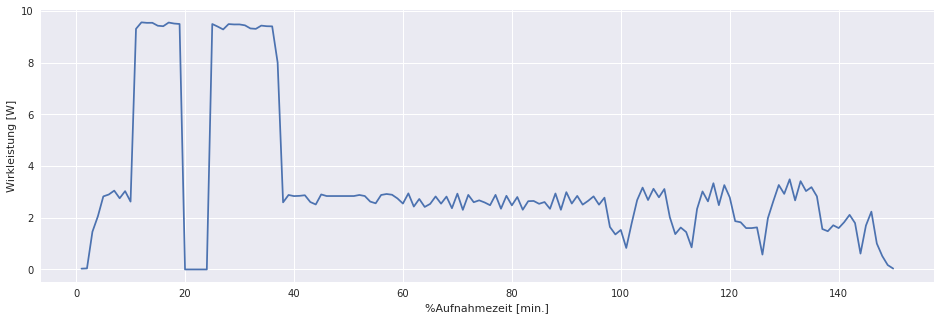

In [4]:
PWaschgang = pd.read_csv('data/wama.csv',header=1)
PWaschgang = PWaschgang.set_index('%Aufnahmezeit [min.]')
ax = PWaschgang['Stromstärke [A]'].plot()
ax.set_ylabel('Wirkleistung [W]')

## Datenqualität

*Daten von niedriger Qualität sind in kommerziellen und wissenschaftlichen Datenbanken **allgegenwärtig**. Produktcodes werden falsch verwendet, Messreihen werden in unterschiedlichen Einheiten erfasst, Kundendaten werden in Call-Centers fehlerhaft eingetippt etc. Solche Datenfehler und Probleme mindern die Datenqualität und haben wirtschaftliche Konsequenzen: Es gilt das sogenannte **garbage-in-garbage-out** Prinzip. Fehler in den Daten verursachen Fehler in daraus generierten Berichten; mangelndes Vertrauen in Daten führt zu Fehlentscheidungen; Chancen werden verpasst wenn Daten verspätet oder unverständlich sind.* [Gesellschaft für Informatik (GI). *Datenqualität* Sept. 2018](https://gi.de/informatiklexikon/datenqualitaet) \cite{informatik_gi_datenqualitat_2018}

### Daten von schlechter Qualität

nach [Erhard Rahm und Hong Hai Do *Data Cleaning: Problems and Current Approaches*, Uni Leipzig 2000](http://dc-pubs.dbs.uni-leipzig.de/files/Rahm2000DataCleaningProblemsand.pdf) \cite{rahm_data_2000}:
- Datenfehler
- Dubletten (doppelte Werte)
- fehlende Werte
- falsche Formatierungen
- Widersprüche

### Datenqualität: Struktureller Überblick

nach [Erhard Rahm und Hong Hai Do *Data Cleaning: Problems and Current Approaches*, Uni Leipzig 2000](http://dc-pubs.dbs.uni-leipzig.de/files/Rahm2000DataCleaningProblemsand.pdf) \cite{rahm_data_2000}:

![Struktur der Datenqualität](img/datenqualitaet.png)

weitere wichtige Aspekte von Datenquelle(n):
- Verständlichkeit
- Vollständigkeit
- Reputation

### Messbare Kriterien für Datenqualität

nach [Gesellschaft für Informatik (GI). *Datenqualität* Sept. 2018](https://gi.de/informatiklexikon/datenqualitaet) \cite{informatik_gi_datenqualitat_2018}:
- viele Kriterien sind qualitativ, z. B. Reputation
- **Vollständigkeit**: z. B. 44% bei OMIM, d.h. Infos über 10.995 der geschätzten 25.000 menschlichen Gene
- **Genauigkeit**: z. B. stichprobenartige Überprüfung der Messgenauigkeit einzelner Datensätze oder -punkte
- **möglichst (automatisiert) eliminieren**: Dubletten und klar unplausible Daten (z. B. durch Überprüfung der Maximalwerte oder Minimalwerte)

### Externe Daten im Nachhinein verbessern

kann man nicht!

einzige Möglichkeit (nach [Gesellschaft für Informatik (GI). *Datenqualität* Sept. 2018](https://gi.de/informatiklexikon/datenqualitaet) \cite{informatik_gi_datenqualitat_2018}): bewusst mit den Daten und ihrer Qualität umgehen, sonst Gefahr falscher Entscheidungen
- geeignete Darstellung, z. B. Zahl der gültigen Ziffern: nicht "80.068.011 Einwohner", sondern "80 Mio."
- Angabe von (ggf. abgeschätzten) Unsicherheitsfaktoren und deren Größe, z. B. "1,16 kWh pro Waschgang im Programm 60°C, je nach Füllgrad $\pm$0,15 kWh"

### Datenqualität: eigene oder aus externen Daten selbst zusammengefasste Daten aktiv verbessern

![Datenentstehungskette kritisch betrachten](img/datenentstehungskette.png)

**am wirkungsvollsten**: Integritätsbedingungen formulieren (z. B. max. Leistung eines Gerätes) oder Konsistenz von Datensätzen sicherstellen (z. B. Energieerhaltung)

**häufig genutzt (transparent dokumentieren!)**: fehlende Werte so ergänzen, dass statistische Größen wie Durchschnitt oder Standardabweichung unverändert bleiben sowie Ausreißer (= wahrscheinliche Datenfehler) erkennen und eliminieren

nach [Gesellschaft für Informatik (GI). *Datenqualität* Sept. 2018](https://gi.de/informatiklexikon/datenqualitaet) \cite{informatik_gi_datenqualitat_2018}

### Beispiel für Ersetzen / Eliminieren von fehlerhaften / fehlenden Daten bei der Waschmaschinenmessung

- richtige Datenspalte in Messdatei auswählen
- Nullstellen ab Minute 20 ersetzen durch ähnliche Werte wie rechts und links (Mittelwert und Streuung im Intervall mit hoher Leistung von Minute 12-38 bleiben gleich)
- seltsam stehen gebliebene Werte ab Minute 50 mit Streuung so ähnlich variieren im Intervall von Minute 40 bis 90
- Energiesumme 1,163 kWh überprüfen

### Daten bereinigen: mit Mittelwert interpolieren

Mittelwert $\bar{x(t)}$ über Zeitintervall $t_1$ bis $t_2$:

\begin{equation}
\bar{x(t)} = \frac{1}{t_2 - t_1} \int_{t_1}^{t_2} x(t)dt
\end{equation}

das wird bei diskreten Messwerten zu einer Summenformel: 

\begin{equation}
\bar{x(t)} = \frac{1}{i(t_2) - i(t_1) + 1} \sum_{i(t_1)}^{i(t_2)} x(t_i)
\end{equation}

In [ ]:
# Beispielwerte
x = np.array([3,0,0,0,5,6,7,9,3])
plt.plot(x,'o')

<div class="alert alert-block alert-info"><b>Ausprobieren: </b>
Berechnen Sie, mit welchen Werten die Nullen interpoliert werden könnten.</div>

*Antwort: Der Mittelwert zwischen $t_1$ und $t_2$ beträgt ...*

In [ ]:
x[x < 1 ] = np.mean([x[0],x[4]])
plt.plot(x,'o')

<div class="alert alert-block alert-warning"><b>Wichtig: Datenkorrekturen immer begründen und dokumentieren! </b>Begründung für Waschmaschine z. B.: Energiesumme bei 1,16 kWh.</div>

### Daten bereinigen: Zufallszahlen hinzufügen

1. Schwankungsbreite festlegen, z. B. 9,279 A bis 9,553 A aus daneben liegenden Messdaten
2. Auflösung festlegen, z. B. 0,004 A als kleinsten Abstand zwischen den gemessenen Stromwerten
3. Verteilung festlegen, z. B. Gleichverteilung oder Normalverteilung

In [ ]:
# neue Beispielwerte
x = np.array([1,3,0,0,0,0,0,0,5,8,7,6,4,8,9,8,7,7,7,8,8,9,6,6,6,5,4])
plt.plot(x,'o-')

In [ ]:
y = np.array([1,3,0,0,0,0,0,0,5,8,7,6,4,8,9,8,7,7,7,8,8,9,6,6,6,5,4])
x[x < 1 ] = 10*np.random.rand(len(x[x<1])) # gleichverteilte Werte - von 0 bis 1
y[y < 1 ] = 10*np.random.randn(len(y[y<1])) # normalverteilte Werte - von .. bis .. 
plt.plot(x,'o-',label='gleichverteilt')
plt.plot(y,'o-',label='normalverteilt')
plt.legend(loc='best')

### Daten bereinigen und wissenschaftliches Fehlverhalten

**Wichtig**: Bereinigung transparent machen<br><br>
Erfundene Daten, die nicht ordnungsgemäß gekennzeichnet waren, haben schon
wissenschaftliche Karrieren zerstört, siehe die Geschichte eines Physikers namens [Jan Hendrik Schön](https://de.wikipedia.org/w/index.php?title=Jan_Hendrik_Sch%C3%B6n&stableid=201319209) \cite{wikipedia_jan_2018}, der seinem Namen alle Ehre machte und Messdaten geschönt hat.

Zudem sind erfundene Daten eine schlechte Entscheidungsgrundlage: 
- auch und besonders erfundene Daten können unplausibel sein und somit zu Fehleinschätzungen führen
- wenn aufgrund fehlerhafter Daten eine Investition getätigt wird, dann ist das Geld oft verloren

Hier im Master sind erfundene Daten, die nicht ordnungsgemäß gekennzeichnet sind, wissenschaftliches Fehlverhalten, im Extremfall eine Note 5,0.

Daten abschätzen und Messdaten bereinigen sind wichtige Aufgaben Ihrer Arbeit. Machen Sie Ihre Annahmen hierfür transparent!

### Datenqualität bei Messdaten: Messungen und Messdaten kritisch betrachten

![Einfache Darstellung der Messkette](img/messkettediagramm.png)

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Finden Sie Beispiele für Messfehler an den verschiedenen Stellen der Messkette:
</div>

*Antwort:...*

Typische weitere Beispiele: 
- ungünstige Plazierung des Sensors, z. B. Temperatursensor in der Sonne (Störsignal)
- Sensor kaputt: z. B. erhöhter Kontaktwiderstand
- Sensor nicht verbunden, z. B. Leitung defekt
- Digitalisierung mit zu niedriger Frequenz oder zu geringer Auflösung
- elektromagnetische Einkopplung in Sensorleitung führt zu verfälschten Werten

### Datenqualität bei Messdaten: Beispiel einer Temperaturmessung

In [ ]:
temperatur = pd.DataFrame()
temperatur['Zeit [s]'] = [1,2,3,4,5]
temperatur['Temperatur [°C]'] = [20.185,21.185,21.185,20.685,20.185]
temperatur.head()

<div class="alert alert-block alert-info"><b>Frage: </b> Ist die Anzahl der Nachkommastellen sinnvoll? Wann wird gerundet - schon bei der Datengrundlage oder erst bei der Darstellung?
</div>

*Antwort:...*

Auflösung dieses Sensorsignals: 0,5°C $\to$ in Darstellungen max. 1 Nachkommastelle sinnvoll

## Visualisierung von großen Datenmengen

### Heatmap Beispiel

<a title="Karsten Adam, GFDL &lt;http://www.gnu.org/copyleft/fdl.html&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Heatmap_fussball.svg"><img width="256" alt="Heatmap fussball" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Heatmap_fussball.svg/256px-Heatmap_fussball.svg.png"></a>

### Beispiel Teppichdiagramm (auch heatmap, carpet plot) einer elektrischen Leistungsmessung übers ganze Jahr

Messung in einer Fabrik, aus einem [Blogpost von Micah Sussmann und Josh Lutton *Energy Storage 301: Solar + Storage Economics*](https://woodlawnassociates.com/energy-storage-301/) \cite{micah_sussmann_energy_2015}

![Teppichdiagramm](https://woodlawnassociates.com/wp-content/uploads/1D-G1130-factory-CA-baseline-heat-map.png)

<div class="alert alert-block alert-info"><b>Frage: </b> Wie plausibel sieht die Leistungsmessung in der Heatmap aus? Und welche anderen Dinge lassen sich aus dieser Heatmap lesen?
</div>

*Antwort:...*

*Hinweis: so eine Frage könnte auch in der mündlichen Prüfung drankommen.*

## Heatmaps in python darstellen

Dieses Notebook beinhaltet einige Wege, wie es grundsätzlich möglich ist Heatmaps zu erzeugen, die aber noch nicht alle das können, was zu einer Heatmap für Energiedaten gehört. Sie können hier also auch sehen, wie man python verwenden kann, um dokumentiert etwas auszuprobieren.

nach http://seaborn.pydata.org/generated/seaborn.heatmap.html

### Erste Heatmap mit Zufallszahlen

In [ ]:
zufallszahlen=np.random.rand(5,6)

In [ ]:
print(zufallszahlen)

In [ ]:
ax=sns.heatmap(zufallszahlen)

unpraktische Skalierung des Farbbalkens ändern, so dass maximaler Wert und minimaler Wert sichtbar sind

In [ ]:
ax=sns.heatmap(zufallszahlen,vmin=0,vmax=1)

### Daten mit Bezeichnungen in einer Heatmap darstellen

Beispieldaten mit Flügen pro Monat aus seaborn

In [ ]:
fluege=sns.load_dataset("flights")

In [ ]:
fluege.head()

umsortieren

In [ ]:
fluege=fluege.pivot("month","year","passengers")

In [ ]:
fluege.head()

In [ ]:
ax=sns.heatmap(fluege)

in jeder Zelle die Anzahl der Flüge eintragen

In [ ]:
ax=sns.heatmap(fluege,annot=True,fmt="d")

Hier ist die oben vordefinierte Schriftgröße ganz offensichtlich zu groß. Aber das ließe sich ja ändern ...

Vermutlich sind das amerikanische Daten, und damals schon war in der Ferienzeit ein höheres Flugaufkommen zu sehen!

In [ ]:
ax=sns.heatmap(fluege,linewidths=.5)

Das ist Geschmackssache - für manche Arten von Daten sicher dienlich, um sie verständlicher zu machen. Bei den Flügen kann man sich streiten, ob es notwendig ist.

Wenn man immer denselben Wert mit der mittleren Farbe der Skala belegen will, kann man das z. B. folgendermaßen erreichen.

In [ ]:
ax=sns.heatmap(fluege,center=fluege.loc["January",1955])

Hier liegt der Wert für Januar 1955 als schwarze Farbe vor.

In [ ]:
data=np.random.randn(50,20)

In [ ]:
ax=sns.heatmap(data,xticklabels=2,yticklabels=False)

### ohne Farbskala?

In [ ]:
ax=sns.heatmap(fluege,cbar=False)

Das ist vor allem dann interessant, wenn man mehrere Heatmaps mit der gleichen Farbgebung hat. Ansonsten fehlen ja die Daten und dann ist es unklar, was ist jetzt viel und wenig in der Darstellung, da sollte man dann die Skala auch nicht weglassen, wenn man nur eine einzige Heatmap erstellt.

### jetzt Energiedaten

erst mal einlesen und zwar nur das erste Datenjahr 2006, weitere Inspiration gibt es hier: https://machinelearningmastery.com/time-series-data-visualization-with-python/ \cite{brownlee_time_2017}- der Datensatz ist wieder aus \cite{minde_household_2017}

In [5]:
opsd_daily2006=pd.read_csv('https://github.com/jenfly/opsd/raw/master/opsd_germany_daily.csv',nrows=365, header=0,index_col=0, parse_dates=True,squeeze=True)

In [6]:
opsd_daily2006.shape

(365, 4)

In [7]:
opsd_daily2006.head(3)

Consumption  Wind  Solar  Wind+Solar
Date                                            
2006-01-01     1069.184   NaN    NaN         NaN
2006-01-02     1380.521   NaN    NaN         NaN
2006-01-03     1442.533   NaN    NaN         NaN

In [8]:
opsd_daily2006.tail(4)

Consumption  Wind  Solar  Wind+Solar
Date                                            
2006-12-28     1314.603   NaN    NaN         NaN
2006-12-29     1274.646   NaN    NaN         NaN
2006-12-30     1237.751   NaN    NaN         NaN
2006-12-31     1144.398   NaN    NaN         NaN

In [9]:
opsd_daily2006.dtypes

Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

In [10]:
groups=opsd_daily2006['Consumption'].groupby(pd.Grouper(freq='A'))

In [11]:
years=pd.DataFrame()

In [12]:
for name,group in groups:
    years[name.year] = group.values

In [13]:
years=years.T

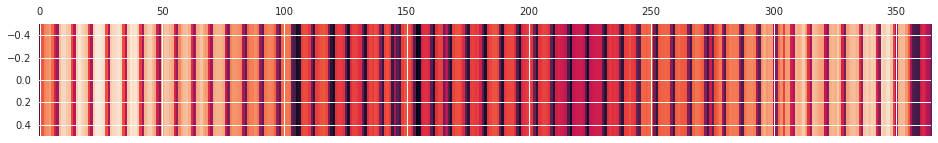

In [14]:
plt.matshow(years,interpolation=None,aspect='auto')

sieht erst mal sinnvoll aus, aber natürlich ist das nur für ein Jahr, jetzt probieren wir dasselbe nun über mehrere Jahre, ohne Schaltjahre (die machen Probleme wegen der 366 statt 365 Datenpunkte)

In [ ]:
opsd_daily=pd.read_csv('https://github.com/jenfly/opsd/raw/master/opsd_germany_daily.csv',header=0,index_col=0, parse_dates=True,squeeze=True,nrows=2*365)

In [ ]:
opsd_daily.shape

In [ ]:
opsd_daily.head(3)

In [ ]:
opsd_daily.tail(4)

In [ ]:
opsd_daily.dtypes

In [ ]:
groups=opsd_daily['Consumption'].groupby(pd.Grouper(freq='A'))

In [ ]:
groups.head(1)

In [ ]:
years=pd.DataFrame()

In [ ]:
for name,group in groups:
    print(name.year)
    years[name.year] = group.values

In [ ]:
years=years.T

In [ ]:
plt.matshow(years,interpolation=None,aspect='auto')

Das ist auch keine so sehr hilfreiche Darstellung deshalb, weil es immer bei Tag 1 losgeht und somit die Wochentagsschwankungen verschoben werden.

### Energiedaten mit seaborn darstellen

inspiriert von diesem Blogpost https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/ \cite{milind_paradkar_using_2016}

In [ ]:
df=pd.read_csv('https://github.com/jenfly/opsd/raw/master/opsd_germany_daily.csv',parse_dates=True,index_col=0,nrows=365)

In [ ]:
df.head()

jetzt fügen wir noch Spalten für Jahr, Monat, Tag, Wochentag hinzu

In [ ]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day']=df.index.day
df['Weekday Name'] = df.index.weekday

In [ ]:
df.head()

In [ ]:
result=df.pivot(index='Month',columns='Day',values='Consumption')

In [ ]:
result.head()

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
title="2006 tägliche elektrische Energiewerte"
plt.title(title,fontsize=18)
ttl=ax.title
ttl.set_position([.5,1.05])
plt.xlabel('Month')
plt.ylabel('Day')
sns.heatmap(result,linewidths=.5,ax=ax)

Wieder suboptimal, denn eigentlich sollten die Wochentage übereinstimmen!

es gibt dafür das Paket calmap (https://pythonhosted.org/calmap/ ), das ist aber nicht standardmäßig bei python dabei und lässt sich gerade nicht hier installieren

### Energiedaten in minütlicher Auflösung darstellen für ein Jahr mit seaborn

erst mal wieder die Daten einlesen

In [ ]:
ls

In [15]:
hh=pd.read_csv('data/household_data_1min_singleindex.csv',index_col=1,parse_dates=True)

In [16]:
hh.head()

utc_timestamp  \
cet_cest_timestamp                                
2015-10-26 13:31:00+01:00  2015-10-26T12:31:00Z   
2015-10-26 13:32:00+01:00  2015-10-26T12:32:00Z   
2015-10-26 13:33:00+01:00  2015-10-26T12:33:00Z   
2015-10-26 13:34:00+01:00  2015-10-26T12:34:00Z   
2015-10-26 13:35:00+01:00  2015-10-26T12:35:00Z   

                           DE_KN_industrial1_grid_import  \
cet_cest_timestamp                                         
2015-10-26 13:31:00+01:00                            NaN   
2015-10-26 13:32:00+01:00                            NaN   
2015-10-26 13:33:00+01:00                            NaN   
2015-10-26 13:34:00+01:00                            NaN   
2015-10-26 13:35:00+01:00                            NaN   

                           DE_KN_industrial1_pv_1  DE_KN_industrial1_pv_2  \
cet_cest_timestamp                                                          
2015-10-26 13:31:00+01:00                     NaN                     NaN   
2015-10-26 13:32:00+01:00                     NaN                     NaN   
2015-10-26 13:33:00+01:00                     NaN                     NaN   
2015-10-26 13:34:00+01:00                     NaN                     NaN   
2015-10-26 13:35:00+01:00                     NaN                     NaN   

                           DE_KN_industrial2_grid_import  \
cet_cest_timestamp                                         
2015-10-26 13:31:00+01:00                            NaN   
2015-10-26 13:32:00+01:00                            NaN   
2015-10-26 13:33:00+01:00                            NaN   
2015-10-26 13:34:00+01:00                            NaN   
2015-10-26 13:35:00+01:00                            NaN   

                           DE_KN_industrial2_pv_1  \
cet_cest_timestamp                                  
2015-10-26 13:31:00+01:00                     NaN   
2015-10-26 13:32:00+01:00                     NaN   
2015-10-26 13:33:00+01:00                     NaN   
2015-10-26 13:34:00+01:00                     NaN   
2015-10-26 13:35:00+01:00                     NaN   

                           DE_KN_industrial2_storage_charge  \
cet_cest_timestamp                                            
2015-10-26 13:31:00+01:00                               NaN   
2015-10-26 13:32:00+01:00                               NaN   
2015-10-26 13:33:00+01:00                               NaN   
2015-10-26 13:34:00+01:00                               NaN   
2015-10-26 13:35:00+01:00                               NaN   

                           DE_KN_industrial2_storage_decharge  \
cet_cest_timestamp                                              
2015-10-26 13:31:00+01:00                                 NaN   
2015-10-26 13:32:00+01:00                                 NaN   
2015-10-26 13:33:00+01:00                                 NaN   
2015-10-26 13:34:00+01:00                                 NaN   
2015-10-26 13:35:00+01:00                                 NaN   

                           DE_KN_industrial3_area_offices  \
cet_cest_timestamp                                          
2015-10-26 13:31:00+01:00                             NaN   
2015-10-26 13:32:00+01:00                             NaN   
2015-10-26 13:33:00+01:00                             NaN   
2015-10-26 13:34:00+01:00                             NaN   
2015-10-26 13:35:00+01:00                             NaN   

                           DE_KN_industrial3_area_room_chemistry  ...  \
cet_cest_timestamp                                                ...   
2015-10-26 13:31:00+01:00                                    NaN  ...   
2015-10-26 13:32:00+01:00                                    NaN  ...   
2015-10-26 13:33:00+01:00                                    NaN  ...   
2015-10-26 13:34:00+01:00                                    NaN  ...   
2015-10-26 13:35:00+01:00                                    NaN  ...   

                           DE_KN_residential5_refrigerator  \
cet_cest_timestamp    

mit CET Zeitstempel, denn das ist mitteleuropäische Zeit

Extra-Spalten hinzufügen

In [17]:
hh['utc_timestamp']=pd.to_datetime(hh.index, utc=True)
hh['Year'] = hh['utc_timestamp'].dt.year
hh['Month'] = hh['utc_timestamp'].dt.month
hh['Day']=hh['utc_timestamp'].dt.day
hh['Weekday Name'] = hh['utc_timestamp'].dt.weekday
hh['Date']=hh['utc_timestamp'].dt.date
hh['Time'] =hh['utc_timestamp'].dt.time

In [18]:
hh2=hh.pivot(index='Date',columns='Time',values='DE_KN_residential5_refrigerator')

In [19]:
hh2.head()

Time        00:00:00  00:01:00  00:02:00  00:03:00  00:04:00  00:05:00  \
Date                                                                     
2015-10-26       NaN       NaN       NaN       NaN       NaN       NaN   
2015-10-27     0.467     0.468     0.469     0.470     0.471     0.472   
2015-10-28     1.357     1.357     1.357     1.357     1.357     1.357   
2015-10-29     2.273     2.273     2.273     2.273     2.273     2.273   
2015-10-30     3.172     3.172     3.172     3.172     3.172     3.172   

Time        00:06:00  00:07:00  00:08:00  00:09:00  ...  23:50:00  23:51:00  \
Date                                                ...                       
2015-10-26       NaN       NaN       NaN       NaN  ...     0.458     0.459   
2015-10-27     0.474     0.475     0.476     0.479  ...     1.356     1.356   
2015-10-28     1.357     1.357     1.357     1.357  ...     2.270     2.271   
2015-10-29     2.273     2.273     2.273     2.273  ...     3.171     3.172   
2015-10-30     3.172     3.172     3.172     3.172  ...     4.069     4.070   

Time        23:52:00  23:53:00  23:54:00  23:55:00  23:56:00  23:57:00  \
Date                                                                     
2015-10-26     0.460     0.460     0.462     0.462     0.463     0.464   
2015-10-27     1.356     1.356     1.356     1.356     1.356     1.356   
2015-10-28     2.272     2.273     2.273     2.273     2.273     2.273   
2015-10-29     3.172     3.172     3.172     3.172     3.172     3.172   
2015-10-30     4.071     4.071     4.071     4.071     4.071     4.071   

Time        23:58:00  23:59:00  
Date                            
2015-10-26     0.465     0.466  
2015-10-27     1.357     1.357  
2015-10-28     2.273     2.273  
2015-10-29     3.172     3.172  
2015-10-30     4.071     4.071  

[5 rows x 1440 columns]

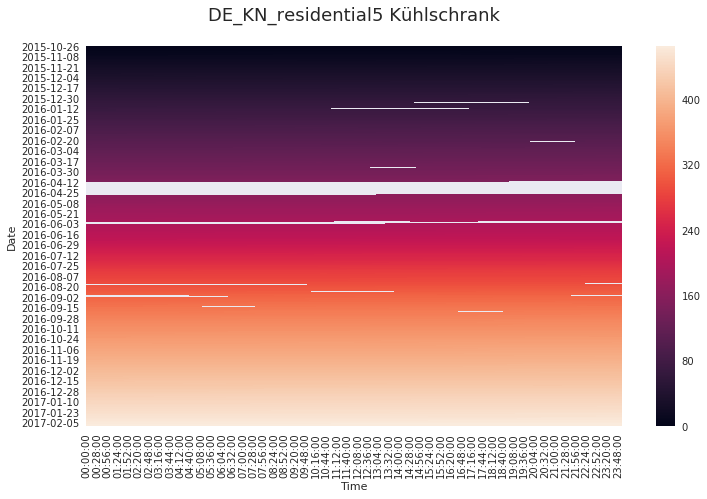

In [20]:
fig,ax=plt.subplots(figsize=(12,7))
title="DE_KN_residential5 Kühlschrank"
plt.title(title,fontsize=18)
ttl=ax.title
ttl.set_position([.5,1.05])
sns.heatmap(hh2)

Das ist die Heatmap des Energieverbrauchs, nicht des Lastprofils. Schön sieht man Fehlstellen in den Daten, aber natürlich ist es nicht so interessant, dass die verbrauchte Energie mit jeder Minute zunimmt. Daher benötigen wir hier die Leistungsdaten.

Wie kommt man von Energie auf Leistung?

inspiriert von hier: https://machinelearningmastery.com/difference-time-series-dataset-python/ \cite{brownlee_how_2017}

In [21]:
hh['Power']=hh['DE_KN_residential5_refrigerator'].diff()

In [22]:
hh3=hh.pivot(index='Date',columns='Time',values='Power')

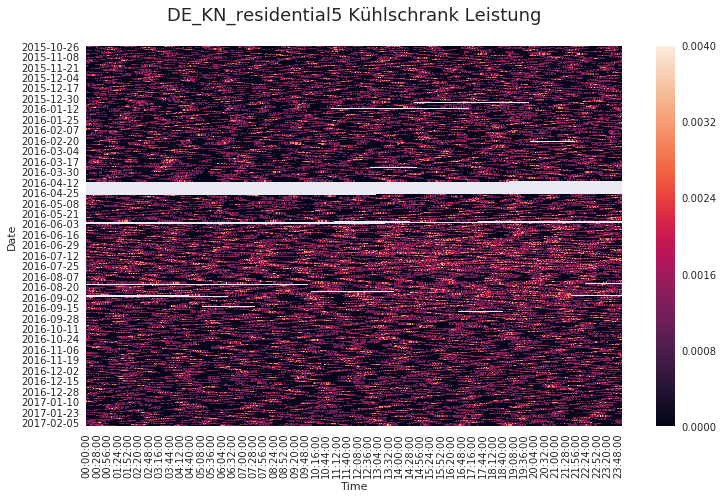

In [23]:
fig,ax=plt.subplots(figsize=(12,7))
title="DE_KN_residential5 Kühlschrank Leistung"
plt.title(title,fontsize=18)
ttl=ax.title
ttl.set_position([.5,1.05])
sns.heatmap(hh3)

wie zu erwarten geht ein Kühlschrank immer wieder an und aus, das ist ohne Regelmäßigkeit ...

## Neue Profile aus gemessenen Daten zusammenstellen

Um die Testdaten des Energieloggers gleich nutzen zu können, verwenden wir eine Funktion zum Einlesen eines Projektes aus 2019 \cite{maximilian_augsdorfer_projektdokumentation_2019}:

In [ ]:
def read_energy_logger_file(path_to_file):

    # Check if path exists
    if not os.path.exists(path_to_file) or not os.path.isfile(path_to_file):
        raise Exception("No file at given path!")
        
    # Read data into pandas dataframe
    df = pd.read_csv(path_to_file, header = 7)

    # Rename columns
    df = df.rename(columns = {"Aufnahmezeit": "timestamp", "Stromstärke (A)": "Current [A]", "Wirkleistung (W)": "Active Power [W]", "Scheinleistung (W)": "Apparent Power [W]"})

    # Since the data provided by the energy logger
    # is not formated correctly for further usage,
    # each cell needs to be reformated.

    # Iterate through dataframe and reformat data
    for index, row in df.iterrows():
        
        # Reformat other columns
        for column in df.columns:
            if not column == "timestamp":
                
                # Get string from cell
                string = row[column].replace(",", ".")

                # Create float from string
                value = float(string)
                
                # Set reformated cell
                row[column] = value

    # Cast data types to float 64
    for column in df.columns:
        if not column == "timestamp":
            df = df.astype({column: 'float64'})
            
            
    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

Um ein kurzes Lastprofil für ein ganzes Jahr zu verschiedenen Zeitpunkten zu verwenden, benötigt man eine Funktion, die dieses Lastprofil auf andere Zeitpunkte kopiert. Ein Projekt hat so eine Funktion in 2019/2020 folgendermaßen gelöst \cite{maximilian_augsdorfer_projektdokumentation_2019}:  Der erste Zeitstempel ist `start_timestamp_string`. Danach wird der Zeitstempel der weiteren Datenreihen um jeweils den in dem Parameter `resolution` übergebenen Wert erhöht. Die Funktion gibt einen angepassten `DataFrame` mit den neuen Zeitstempeln zurück.

In [ ]:
def map_timestamp(df, start_timestamp_string, resolution = 1, column_name = "timestamp"):
    
    # Create datetime object from start timestamp
    start_timestamp = datetime.datetime.strptime(start_timestamp_string, "%d-%m-%Y %H:%M:%S")
    
    timestamps = []
    
    # Iterate through data frame rows
    for idx, row in df.iterrows():
        
        # Create mapped timestamp
        mapped_timestamp = start_timestamp + datetime.timedelta(minutes = len(timestamps) * resolution)
        
        # Append timestamp
        timestamps.append(mapped_timestamp)
        
    
    df[column_name] = timestamps
    
    
    # Return mapped data frame
    return df

Dasselbe Projekt hat auch eine Funktion zur Erstellung eines Zeitraums ohne oder mit konstanter Last geschrieben \cite{maximilian_augsdorfer_projektdokumentation_2019}: Der Parameter `size` gibt an, wie viele aufeinander folgende Reihen mit jeweils dem gleichen Zahlenwert (`value`) erzeugt werden sollen. Die Funktion bezieht sich immer auf einen Tageszeitraum. D.h. das damit erzeugte Profil muss dann mithilfe der obigen Funktion `map_timestamp` wieder vervielfältigt werden.

In [ ]:
def create_uniform_dataframe(size, value):
    values = []
    
    for i in range(0, size):
        values.append(value)
    
    timestamps = ["01-01-2019 00:00:00" for x in range(size)]

    df = pd.DataFrame()
    
    df["timestamp"] = timestamps
    df["Current [A]"] = values
    df["Active Power [W]"] = values
    df["Apparent Power [W]"] = values

    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

Um nun mehrere DataFrames zusammenzufügen zu einem einzigen DataFrame, der dann sowohl synthetisch generierte als auch gemessene Daten erhält, schlägt das Projekt zudem noch die Nutzung des `concat`-Befehls vor \cite{maximilian_augsdorfer_projektdokumentation_2019}: Zunächst passt die Funktion den Zeitstempel der einzelnen DataFrames an und setzt dafür die obige Funktion `map_timestamp` ein. Der Übergabe-Parameter `dfs` enthält ein Array mit Tupeln: Der erste Index eines jeden Tupels ist der `DataFrame`, der die Daten enthält. Der zweite Index ist ein `String`, der den Start-Zeitstempel beinhaltet. So ist es möglich, eine kürzere Messreihe mehrfach hintereinander zu hängen, ohne dass Inkonsistenzen bei den Zeitstempeln auftreten. 

In [ ]:
def concat_data(dfs):
    
    # dfs in tuple-format: (dataFrame, startTimestamp)
    
    # Prepare data frames
    dfsToConcat = []
    
    # Set timestamps
    for df in dfs:
        mapped_df = map_timestamp(df[0], df[1])
        dfsToConcat.append(mapped_df.copy())
        
    return pd.concat(dfsToConcat)

In [ ]:
def timestamp_based_concat(df, start_timestamp_string, number_of_concats, offset):
    result = []
    
    # Create datetime object from start timestamp
    start_timestamp = datetime.datetime.strptime(start_timestamp_string, "%d-%m-%Y %H:%M:%S")

    for i in range(0, number_of_concats):
        
        timestamp = start_timestamp + datetime.timedelta(minutes = offset * i)
        timestamp_string = timestamp.strftime("%d-%m-%Y %H:%M:%S")
        
        result.append((df.copy(), timestamp_string))
        
    return result

Nun ein Beispiel mit den Testdaten einer Energieloggermessung:

In [ ]:
# einlesen und Variablen vorbereiten
testdaten = read_energy_logger_file('data/Energieloggertestdaten.csv')
standbydf = create_uniform_dataframe(30,.5)
jahresenergie = {}
# Tag erstellen
testdaten_fd_dfs = timestamp_based_concat(standbydf, "03-01-2021 00:00:00", 16, 30)
testdaten_fd_dfs.extend(timestamp_based_concat(testdaten, "03-01-2021 08:00:00", 16, 30))
testdaten_fd_dfs.extend(timestamp_based_concat(standbydf, "03-01-2021 16:00:00", 16, 30))
testdaten_fd = concat_data(testdaten_fd_dfs)
testdaten_fd.head()

In [ ]:
testdaten_fd.plot(x='timestamp')

## Varianz von Daten

### Reproduzierbarkeit und Schwankungen bei mehrfachen Messungen

Beispiele: 
- Wie stark variiert die jährliche Solarstrahlung in DE?
- Wie stark variiert der jährliche Stromverbrauch einer vierköpfigen Familie?
- Was, wenn noch ein Kind geboren wird?
- Was, wenn eins auszieht? (Oder wegen Corona wieder zuhause einzieht?)
- Wie stark variiert der Energiebedarf einer Waschmaschine bei unterschiedlichen Beladungen (im gleichen Programm)?
- Was, wenn das Wasser besonders kalt aus der Leitung kommt?

<div class="alert alert-block alert-info"><b>Frage: </b> Einige Einflussgrößen auf Energienutzung lassen sich nicht konstant
halten, jedenfalls nicht über mehrere Jahre. Diese Einflussgrößen
stellen sozusagen Störgrößen für die energetische Optimierung dar: Was
heißt das für Ihre Optimierungsbemühungen?
</div>

### Umgang mit variierenden Randbedingungen

Fiktive Daten einer Energieberatung: welche energetische Optimierung lohnt?

![Fiktive Daten einer Energieberatung](img/fiktiveoptimierung.png)

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Sammeln Sie in Ihrem Projekt Einflussgrößen, die variabel sein könnten. Überlegen Sie auch, wie Sie diese berücksichtigen können.
</div>

## Sankey-Diagramm: Übersicht über (Energie-)Flüsse

<div class="alert alert-block alert-info"><b>Tipp: </b> Der Blog <a href="http://www.sankey-diagrams.com">Sankey-Diagrams.com</a> enthält viele Beispiele für Sankey-Diagramme und kritisiert auch, welche besonders gut gelungen sind.
</div>

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Sehen Sie sich den Blog an und finden Sie ein besonders interessantes, besonders gut oder schlecht gelungenes Sankey-Diagramm und stellen Sie es dann im Plenum vor.
</div>

*Antwort: Besondere Sankey-Diagramme sind ... weil ...*

### Formale Anforderungen an ein Sankey-Diagramm

- Breite der Pfeile proportional zur Prozentzahl
- Knotenregel gilt: Summe der Flüsse hinein in ein System muss gleich der Summe der Flüsse hinaus sein
- Flüsse müssen dieselbe Einheit haben, z. B. Energie, Leistung, Material, $CO_2$

## Energieströme und zugehörige Messgrößen (nach \cite{hesselbach_energie-_2012})

| **Energiestrom** | **Formelbeschreibung** | **Messgröße(n)** | **Bemerkung** |
|-|-|-|-|
| Elektrische Wirkleistung $P$ | $P = S\cdot \lambda$ | $u(t)$, $i(t)$ | häufig integrierte Messgeräte |
| Lichtleistung | $E_\nu = d\Phi_\nu / dA$ | Beleuchtungsstärke (lux), W/m² | sichtbar $E_\nu \neq E_{ges}$ |
| Druckluft | $P_{\text{DL}} = \dot{V}\cdot p_{\text{DL}}$ | $\dot{V}$, $p_{\text{DL}}$ | Normbedingungen |   
| Hydraulik | $P_{\text{Hy}} = \dot{V}\cdot p_{\text{Hy}}$ | $\dot{V}$, $p_{\text{Hy}}$ | ` ` |   
| Wärme (Konvektion) | $\dot{q_{\text{conv}}} = \alpha_{\text{conv}} \cdot (T_{\text{Wand}} - T_{\text{Umgebung}})$ | $T_{\text{Wand}}$, $T_{\text{Umgebung}}$ | $\alpha$ aus Tabellen oder Nebenrechnungen | 
| Wärme (Durchgang) | $\dot{q} = U_{\text{th}} \cdot (T_i - T_a)$ | $T_i$, $T_a$ | $U_{\text{th}}$ aus Tabellen oder Nebenrechnungen |
| Wärme (Strahlung) | $\dot{q_{\text{rad,12}}} = \sigma_{12} \cdot (T_1^4 - T_2^4)$ | $T_1$, $T_2$ | $\sigma_{12}$ aus Kalibriermessungen | 
| Wärme (Enthalpiestrom) | $\dot{q_h} = \dot{m_c}\cdot(T_{\text{ein}} - T_{\text{aus}})$ | $\dot{m}$, $T_\text{ein}$, $T_{\text{aus}}$ | Wärmekapazitäten $c$ aus Tabellen |
| Wärme (Verbrennung) | $\dot{q} = \eta_{\text{WE}}\cdot\dot{m_{\text{Brennst}}}\cdot\Delta h_{\text{u,Brennst}}$ | $\dot{m_{\text{Brennst}}}$ | Verbrennungsenthalpie aus Tabellen |
| Wärme (Phasenübergang) | $\dot{q_{\text{12,rev}}}\approx\dot{m}\cdot r_D$ | $\dot{m}$ | Enthalpie aus Tabellen | 

## Quellen für Energiedaten

nach [Jens Hessebach *Daten beschaffen* In *Energie- und klimaeffiziente Produktion*, Wiesbaden, Vieweg+Teubner Verlag, 2012, Seiten 55-93, ISBN 978-3-8348-0448-8 978-3-8348-9956-9](http://www.springerlink.com/index/10.1007/978-3-8348-9956-9_3) \cite{hesselbach_energie-_2012}

![Quellen für Energiedaten](img/energiedatenquellen.png)

### Energiedaten Top-Down analysieren: vom Gesamtverbrauch auf den Einzelverbrauch schließen

- Produktionsbetriebe: Protokolle der Energieversorger
 - ab 100 MWh Stromverbrauch mit 15 Minuten Auflösung
 - ab 1,5 Mio. kWh Erdgasverbrauch mit 1 Stunde Auflösung
- Analyse von
 - Gesamtverbrauch (auch im Vergleich)
 - Verbrauchsmuster (Jahr, Monat, Woche, Tag)
 - Maximale, minimale und Durchschnittslast
 - bei zu bestehenden Anlagen: Produktionsdaten (indirekte Info)
 - bei zu planenden Systemen: Vergleichssysteme, Überschlagsrechnungen, Simulationen

### Energiedaten Top-Down analysieren: Beispieldaten 2017 von [Gildemeister Efficient Factory](https://www.efficientfactory.de) \cite{optenda_energy_2020}: Gesamtverbrauch

In [ ]:
factorydata = pd.read_csv('data/VerbrauchEfficientFactoryGildemeister.csv')
factorydata.rename(columns = {'0':'Jahresstunde'}, inplace = True)
factorydata.rename(columns = {'10860':'LeistungkW'}, inplace = True)
factorydata.plot(x='Jahresstunde', y='LeistungkW')

In [ ]:
print('Gesamtverbrauch 2017: ' +str(np.round(0.25*1e-6*sum(factorydata['LeistungkW']),2)) + ' GWh')

Vergleich mit Daten aus Vorjahren: 
- Gesamtverbrauch 2016: 609,31 GWh
- Gesamtverbrauch 2015: 607,19 GWh $\to$ Einsparmaßnahme 2017?

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Welche Verbrauchsmuster sehen Sie? Gehen Sie selbst auf die Seite (Logindaten im ilias) und suchen Sie einige Muster heraus. Welche Muster sind zu sehen? <i>Hinweis: links unten können Sie einstellen, dass Wochenenden deutlich markiert werden und die Temperaturkurve angezeigt wird</i> Ergeben sich deutliche Unterschiede bei maximaler, minimaler oder Durchschnittslast?
</div>

*Antwort: ...*

### Jahresdauerlinie: sortiert Leistungswerte nach Größe

In [ ]:
factorydata['sortiertkW'] = sorted(factorydata['LeistungkW'], reverse=True)
fd = factorydata.plot(y='sortiertkW')
fd.set_xlabel=('Viertelstundenwerte')

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Was sehen Sie? Was fällt auf? Welche Energieoptimierungspotenziale sind besonders interessant?
   
</div>

*Antwort: ...*

### Histogramm: zeigt Häufigkeit der Leistungswerte auf

In [ ]:
factorydata.plot.hist(y='LeistungkW')

### Nutzen von Top-Down-Daten: Iteratives Vorgehen bei der Analyse

![Iteratives Vorgehen bei der Analyse von Top-Down-Daten](img/topdowndatenanalyseiterieren.png)

### Bottom-Up-Analyse: Typenschilder zählen

- auf Typenschildern von Maschinen, Anlagen, Geräten findet sich die Nennleistung
 - Problem 1: Welche Geräte benötigen die ganze Zeit die Nennleistung?
 - Problem 2: Ist die Nennleistung die maximale Last, die Dauerlast (für welche Dauer) und wie viel Überlast fällt an?
 - Problem 3: Nach welcher Größe werden elektrische Betriebsmittel (Leitungen, Sicherungen, Transformatoren, etc.) ausgelegt?
- Systematische Überdimensionierung von elektrischen Betriebsmitteln: Addition aller Nennleistungen plus Sicherheitszuschlag jeweils auf Planungsebene (20-30%)

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Welchen Nutzen haben Leistungsangaben für die Energieeffizienzanalyse? Diskutieren Sie in Kleingruppen.
   
</div>

*Antwort: ...*

| **Parameter** | ![Weinkühlschrank](https://images.unsplash.com/photo-1567196279979-3bf2f62e8d35?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=967&q=80) | ![Hinten Mitte Weinkühlschrank in Küche](https://images.unsplash.com/photo-1579725942955-4d8377f8c66a?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=967&q=80) |![Schaumwein - vielleicht in einem Weinkühlschrank](https://images.unsplash.com/photo-1561955147-e9083536e573?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80) |
|-|-|-|-|
| **Bildquelle** | Nick Fewings, Unsplash | Obi Onyeador, Unsplash | Amy Chen, Unsplash | 
| **Marke** | Weintraum | CoolWine | NoName |
| **$P_N$** | 200 W | 60 W | 90 W |
| **Volumen** | 368 l | 280 l | 377 l |
| **Verbrauch** | 212 kWh/a | 139 kWh/a | 103 kWh/a |
| **Strom** | 10 A | 10 A | 10 A |
| **Spannung** | 230 V | 230 V | 230 V |

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Hinterfragen Sie die gegebenen (fiktiven) Werte für Weinkühlschränke. Woher kommen die Abweichungen und sind diese logisch? Welche Informationen benötigen Sie, um realistische Verbrauchsprofile zu erstellen?
   
</div>

*Antwort:...*

### ABC-Analyse von Verbrauchern

- relative Sortierung anhand von Typenschildangaben
- A: Großverbraucher: möglichst einzeln erfassen und auswerten
- B: weder A noch C
- C: Kleinverbraucher: entweder zusammenfassen oder repräsentative Einzelmessungen verwenden

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Diskutieren Sie für Ihr Projekt: welche Aspekte Ihrer Geräte sind A, B oder C? Wo brauchen Sie genaue Messungen / Berechnungen? Wo reichen ungenauere?
   
</div>

*Antwort: ...*

## Frequenzanalyse der Stromwerte: Fingerprinting von Verbrauchern

Stichwort in der Literatur: **NILM** = Non-Intrusive Load Monitoring

- Charakteristische Oberwellenanteile gehören zu besonderen Verbrauchern
- Beispiel: LED-Leuchte
- wenn man, z. B. mithilfe eines lernenden Algorithmus, herausgefunden hat, welcher Verbraucher welchen "Fingerabdruck" hat, kann man verschiedene Dinge mit den Daten anfangen:
 - "wenn morgens um 8 die Kaffemaschine läuft, ist Oma gesund" (Stichwort **Ambient Assisted Living** (AAL)
 - Verbrauchsprofile unbekannter Kunden analysieren und erste Tipps für Verbesserungen aufgrund des Fingerabdrucks ableiten

<div class="alert alert-block alert-info"><b>Aufgabe: </b> Suchen Sie in der Begleitliteratur zu den hochaufgelösten Lastprofilen für das Projekt nach charakteristischem Verhalten von einzelnen Geräten. Welche Merkmale haben bestimmte Verbraucher, auf welche Stromsignalanteile sollte man achten?
   
</div>

*Antwort: ...*

## Fingerprinting von hochaufgelösten Daten und wie man hochaufgelöste Daten auf niedrigere Auflösung herunterrechnen kann

Es empfiehlt sich, hier eine Funktion zu schreiben, die einmalig die Daten von HDF5 mit ms-Auflösung auf eine geringere Auflösung herunterrechnet und diese neu abspeichert als csv. Dann kann man immer mit einer `if`-Abfrage prüfen, ob das bereits geschehen ist und wenn ja, diese csv-Datei weiter verarbeiten (und so viel Zeit sparen). 

\cite{medico_voltage_2020} enthält umfangreiche Erklärungen zu solchen Datensätzen, die sich auf [figshare](https://figshare.com/articles/PLAID_-_A_Voltage_and_Current_Measurement_Dataset_for_Plug_Load_Appliance_Identification_in_Households/10084619/2) \cite{medico_plaid_2020} 
befinden. Die `json`-Datei mit den Metadaten besagt (neben vielen weiteren Metadaten), dass Datensatz 2 eine Kaffeemaschine beinhaltet. Im Paper \cite{medico_voltage_2020} steht, dass die csv-Dateien (submetered) Zustandsänderungen zeigen in 30 kHz Auflösung, z. B. Aus-An. 

In [ ]:
spaltennamen = ['Strom [A]', 'Spannung [V]']
schalttestkaffeemaschine = pd.read_csv('data/2.csv', names=spaltennamen, header=None)
schalttestkaffeemaschine.head()

In [ ]:
schalttestkaffeemaschine.plot()

Hier sieht man den amerikanischen Spannungsverlauf und einen kleinen Strom-Peak, der offenbar durch den Einschaltvorgang hervorgerufen wird.

Der "Fingerprint" des Anschaltvorgangs lässt sich mit FFT ([Fast-Fourier-Transform](https://de.wikipedia.org/wiki/Schnelle_Fourier-Transformation) ist eine Abwandlung der diskreten Fourier-Transformation) berechnen:

In [ ]:
teststromfingerabdruck = np.fft.fft(schalttestkaffeemaschine['Strom [A]'])
plt.plot(np.abs(teststromfingerabdruck[0:30000]))

Führt man so eine FFT in Echtzeit durch, kann man - falls das eindeutig anders ist bei der Kaffeemaschine als bei den anderen Geräten - z. B. erkennen, ob die Oma aufgestanden ist, um sich einen Kaffee zu machen (oder ob sie seltsamerweise nicht aufgestanden ist, weil es ihr vielleicht nicht gut geht). Übrigens nutzt auch die App Shazam für die Ermittlung von Liedern die FFT.

\cite{pereira_dscleaner_2019} beschreibt eine Bibliothek, um hochaufgelöste Datensätze zu bereinigen. Dies führt vermutlich zu weit, da es z. B. um minimale Synchronisationsfehler beim Zeitstempel geht. Diese sind relevant, wenn man Fingerprinting machen will, denn dann kommt es darauf an, dass auch minimale Messfehler bereinigt sind.

\cite{carattino_how_2018} erklärt, wie man HDF5-Dateien in python erstellen kann: Das Format hat den Vorteil, dass nicht der gesamte Datensatz (der oft den Arbeitsspeicher sprengen würde) eingelesen wird, sondern dass nur dann Daten eingelesen werden, wenn sie benötigt werden.

Um die Daten einfach anzusehen, stellt die HDF5 Group einen Viewer bereit, der [HDFView](https://portal.hdfgroup.org/display/support/Download+HDFView) heißt. Ich habe ihn allerdings nicht getestet - wie alle Software-Tools hier besonders auch Nutzung auf eigene Gefahr! 

\cite{bhanot_working_2020} zeigt auf, wie man einen einzelnen Datensatz aus einem HDF5-Objekt extrahiert und als csv abspeichert:

In [ ]:
plaiddata = h5py.File('data/plaid_new_.hdf5','r')
plaiddata.keys()

Was das heißt, steht in der PLAID-Doku (weiter oben verlinkt). Nun sehen wir uns an, was in `aggregated` enthalten ist:

In [ ]:
aggregated = plaiddata['aggregated']
aggregated.keys()

\cite{clint_converting_2015} zeigt noch ein Beispiel, wie man HDF5 als CSV auslesen kann.

Im Notebook [SYE erste Energiedatenanalyse](SYE-Projekte.ipynb) findet sich zudem dann eine Anleitung, wie man die Auflösung reduziert (englisch downsample). 

# References

(<a id="cit-energieagenturnrw_kurzenergiecheck_2020" href="#call-energieagenturnrw_kurzenergiecheck_2020">Energieagentur.NRW, 2020</a>)  Energieagentur.NRW, ``_Kurz.Energiecheck – ein Service der EnergieAgentur.NRW_'',  2020.  [online](https://unternehmen.energieagentur.nrw/KurzEnergieCheck/)

(<a id="cit-informatik_gi_datenqualitat_2018" href="#call-informatik_gi_datenqualitat_2018">Informatik ({GI}), 2018</a>) Gesellschaft für Informatik ({GI}), ``_Datenqualität_'',  2018.  [online](https://gi.de/informatiklexikon/datenqualitaet/)

(<a id="cit-rahm_data_2000" href="#call-rahm_data_2000">Rahm and Do, 2000</a>) Rahm Erhard and Do Hong Hai, ``_Data Cleaning: Problems and Current Approaches_'', , vol. , number , pp. 11,  2000.

(<a id="cit-wikipedia_jan_2018" href="#call-wikipedia_jan_2018">wikipedia, 2018</a>)  wikipedia, ``_Jan Hendrik Schön_'',  2018.  [online](https://de.wikipedia.org/w/index.php?title=Jan_Hendrik_Sch%C3%B6n&oldid=176585951)

(<a id="cit-micah_sussmann_energy_2015" href="#call-micah_sussmann_energy_2015">Micah Sussmann} and {Josh Lutton, 2015</a>)  Micah Sussmann} and {Josh Lutton, ``_Energy Storage 301: Solar + Storage Economics_'',  2015.  [online](https://woodlawnassociates.com/energy-storage-301/)

(<a id="cit-brownlee_time_2017" href="#call-brownlee_time_2017">Brownlee, 2017</a>) Jason Brownlee, ``_Time Series Data Visualization with Python_'',  2017.  [online](https://machinelearningmastery.com/time-series-data-visualization-with-python/)

(<a id="cit-minde_household_2017" href="#call-minde_household_2017">Minde, 2017</a>) Adrian Minde, ``_Household Data_'',  2017.  [online](https://data.open-power-system-data.org/household_data/2017-11-10)

(<a id="cit-milind_paradkar_using_2016" href="#call-milind_paradkar_using_2016">Milind Paradkar, 2016</a>)  Milind Paradkar, ``_Using Seaborn Python Package for Creating Heatmap_'',  2016.  [online](https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/)

(<a id="cit-brownlee_how_2017" href="#call-brownlee_how_2017">Brownlee, 2017</a>) Jason Brownlee, ``_How to Difference a Time Series Dataset with Python_'',  2017.  [online](https://machinelearningmastery.com/difference-time-series-dataset-python/)

(<a id="cit-maximilian_augsdorfer_projektdokumentation_2019" href="#call-maximilian_augsdorfer_projektdokumentation_2019">Maximilian Augsdörfer} and {Maximilian von Hirschheydt} and {Lars Petersen} and {Benedikt Remmel, 2020</a>)  Maximilian Augsdörfer} and {Maximilian von Hirschheydt} and {Lars Petersen} and {Benedikt Remmel, ``_Projektdokumentation SYE Projektgruppe 3 Wintersemester 2019/2020_'',  2020.

(<a id="cit-hesselbach_energie-_2012" href="#call-hesselbach_energie-_2012">Hesselbach, 2012</a>) Jens Hesselbach, ``_Energie- und klimaeffiziente Produktion: Grundlagen, Leitlinien und Praxisbeispiele ; mit 34 Tabellen_'',  2012.

(<a id="cit-optenda_energy_2020" href="#call-optenda_energy_2020">Optenda, 2020</a>)  Optenda, ``_Energy Monitor_'',  2020.  [online](https://www.efficientfactory.de/login/?next=https%3A//www.efficientfactory.de/)

(<a id="cit-medico_voltage_2020" href="#call-medico_voltage_2020">Medico, De Baets <em>et al.</em>, 2020</a>) Medico Roberto, De Baets Leen, Gao Jingkun <em>et al.</em>, ``_A voltage and current measurement dataset for plug load appliance identification in households_'', , vol. 7, number 1, pp. 49,  2020.  [online](http://www.nature.com/articles/s41597-020-0389-7)

(<a id="cit-medico_plaid_2020" href="#call-medico_plaid_2020">Medico, Baets <em>et al.</em>, 2020</a>) Roberto Medico, Leen De Baets, Jingkun  <em>et al.</em>, ``_PLAID 2018_'',  2020.  [online](https://figshare.com/articles/PLAID_-_A_Voltage_and_Current_Measurement_Dataset_for_Plug_Load_Appliance_Identification_in_Households/10084619/2)

(<a id="cit-pereira_dscleaner_2019" href="#call-pereira_dscleaner_2019">Pereira, Velosa <em>et al.</em>, 2019</a>) Pereira Manuel, Velosa Nuno and Pereira Lucas, ``_dsCleaner: A Python Library to Clean, Preprocess and Convert Non-Instrusive Load Monitoring Datasets_'', , vol. 4, number 3, pp. 123,  2019.  [online](https://www.mdpi.com/2306-5729/4/3/123)

(<a id="cit-carattino_how_2018" href="#call-carattino_how_2018">Carattino, 2018</a>) Aquiles Carattino, ``_How to use HDF5 files in Python_'',  2018.  [online](/blog/how-to-use-hdf5-files-in-python/)

(<a id="cit-bhanot_working_2020" href="#call-bhanot_working_2020">Bhanot, 2020</a>) Karan Bhanot, ``_Working with HDF5 files and creating CSV files_'',  2020.  [online](https://towardsdatascience.com/working-with-hdf5-files-and-creating-csv-files-1a7d212d970f)

(<a id="cit-clint_converting_2015" href="#call-clint_converting_2015">Clint, 2015</a>)  Clint, ``_Converting HDF5 to CSV – Clint's Blog_'',  2015.  [online](https://clint.id.au/?p=161)

